In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

### Reflecting tables to SQLalchemy ORM

In [6]:
# python SQL toolkit and ORM 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine('sqlite:///resources/hawaii.sqlite')

In [8]:
# reflect an existing database to a new model
# reflecet the tables
base = automap_base()
base.prepare(engine, reflect=True)

In [9]:
# view all the classes found by automap
base.classes.keys()

['measurement', 'station']

In [10]:
# save reference to each table
measurement=base.classes.measurement
station=base.classes.station

In [11]:
# create session link from python db
session=Session(engine)

In [12]:
first_row=session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd4502af390>,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [13]:
first_row=session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fd4502af550>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

### explorative analysis 

#### climate analysis

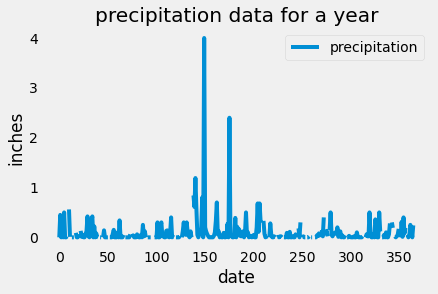

In [14]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
year_data=session.query(measurement.date, measurement.prcp).\
    order_by(measurement.date.desc()).limit(365).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
year_data_df=pd.DataFrame(year_data, columns=['date', 'precipitation']).\
    sort_values('date', ascending=False).\
    reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
# plot the precipatation data
year_data_df.iloc[::-1].plot(title='precipitation data for a year')
plt.tight_layout()
plt.ylabel('inches')
plt.xlabel('date')
plt.grid()
plt.show()

In [15]:
session.query(measurement.date).order_by(measurement.date.desc()).first()
query_date=dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'One year from the last data point in precipitation was :{query_date}')

One year from the last data point in precipitation was :2016-08-23


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_data_df.describe()

,precipitation
count,329.000000
mean,0.105137
std,0.296032
min,0.000000
25%,0.000000
50%,0.020000
75%,0.100000
max,4.000000


#### station analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
stations_count=session.query(station).group_by(station.station).\
    count()
print(f'There are {stations_count} stations in this dataset')

There are 9 stations in this dataset


In [18]:
# List the stations and the counts in descending order.
stations_data=session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()
stations_data   

df=pd.DataFrame(stations_data, columns=['station id', 'count'])
df

,station id,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_counts=session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).first()
    
print('station with most counts')
print('-'*30)
print(f'station id: {most_counts[0]}, counts: {most_counts[1]}')




station with most counts
------------------------------
station id: USC00519281, counts: 2772


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
data=session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), 
                    func.avg(measurement.tobs)).\
                        order_by(func.count(measurement.station).desc()).\
                            group_by(measurement.station).first()
print('Most active station details;')
print('-'*40)
print(f'station id: {data[0]}')
print('-'*20)
print(f'min temp: {data[1]}')
print('-'*20)
print(f'max temp: {data[2]}')
print('-'*20)
print(f'avg temp: {round(data[3],1)}')


Most active station details;
----------------------------------------
station id: USC00519281
--------------------
min temp: 54.0
--------------------
max temp: 85.0
--------------------
avg temp: 71.7


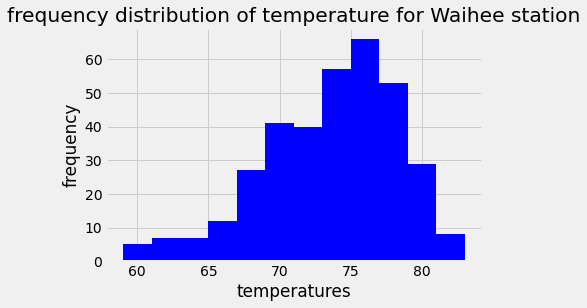

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
final=session.query(measurement.station, measurement.tobs).\
                            filter(measurement.date>='2016-08-23').\
                                filter(measurement.date<='2017-08-23').\
                                    filter(measurement.station=='USC00519281').all()
temps=[result[1] for result in final]
plt.hist(temps, bins=12, color='blue', label='tobs')
plt.title('frequency distribution of temperature for Waihee station')
plt.ylabel('frequency')
plt.xlabel('temperatures')
plt.show()

##### bonus

###### temperature analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


[(61.0, 69.4758064516129, 78.0)]


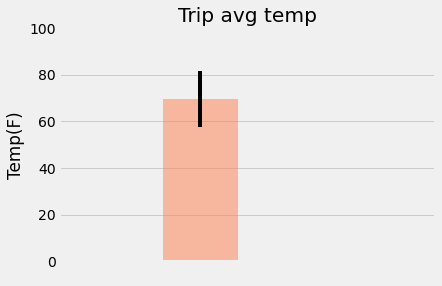

In [148]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-01-02', '2016-01-22'))
plt.bar(' ', height=69.57, align='center',color='coral', yerr=(74-62), alpha=0.5)
plt.title('Trip avg temp')
plt.ylim(0,100)
plt.xlim(-1.5, 2.5)
plt.grid(axis='x')
plt.ylabel('Temp(F)')
plt.show()



###### daly rainfall average

In [77]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall=session.query(station.name,station.latitude,station.longitude,station.elevation, func.sum(measurement.prcp)).\
        filter(measurement.date >= '2017-01-01').filter(measurement.date <= '2018-01-01').\
                group_by(measurement.station).\
                        order_by(func.sum(measurement.prcp).desc()).all()
pd.DataFrame(rainfall, columns=['station', 'latitude','longitude','elevation','total prcp'])

,station,latitude,longitude,elevation,total prcp
0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,619.02
1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,392.94
2,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,311.58
3,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,245.88
4,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,196.20
5,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,95.94
6,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,30.51


In [149]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [175]:
# Set the start and end date of the trip
start_date='2016-01-02'
end_date='2016-01-22'


# Use the start and end date to create a range of dates
days=pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
trip_days=days.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for days in trip_days:
    normals.append(*daily_normals(days))
normals


[(60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0),
 (61.0, 70.14545454545454, 76.0),
 (60.0, 69.26415094339623, 76.0)]

In [195]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
days=pd.date_range(start_date, end_date)
df['dates']=days
df=df.set_index('dates')
df.head()

,tmin,tavg,tmax
dates,,,
2016-01-02,60.0,69.396226,77.0
2016-01-03,62.0,68.909091,77.0
2016-01-04,58.0,70.000000,76.0
2016-01-05,56.0,67.964286,76.0
2016-01-06,61.0,68.964912,76.0


<Figure size 432x288 with 0 Axes>

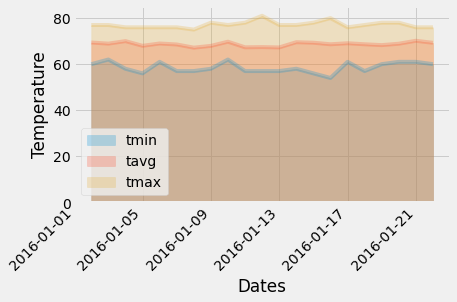

<Figure size 432x288 with 0 Axes>

In [196]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, alpha=0.26, x_compat=True)
plt.ylabel('Temperature')
plt.xlabel('Dates')
plt.xticks(rotation=45, ha='right')
plt.figure()